In [25]:
%matplotlib inline
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (10,8)
import matplotlib.pyplot as plt

import numpy as np
import imageio
import torch
import torchvision

batch_size = 2
device = torch.device('cpu') #torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print ('device: ', device)

device:  cpu


(torch.Size([2, 3, 375, 500]), torch.float32)

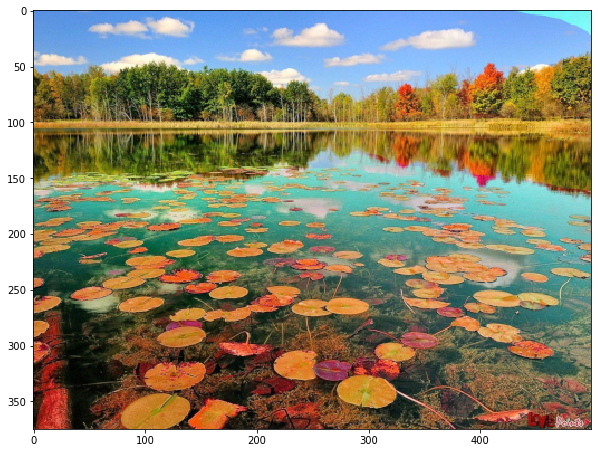

In [26]:
im = imageio.imread ('images/nature-500x375.jpg')
plt.imshow(im)
#im = torch.tensor(im.transpose(2,0,1)).unsqueeze(0).to(device)
imtt = torch.tensor(im).permute(2,0,1).to(device)
im_batch_tensor = torch.stack( [imtt, imtt] ).type(torch.float32) / 255. 
im_batch_tensor.shape, im_batch_tensor.dtype

Generate target meshgrid; a backward transformation will be applied.

In [27]:
N,C,H,W = im_batch_tensor.shape
grow, gcol = torch.meshgrid( [torch.linspace(-1,1,H), torch.linspace(-1,1,W)] )
print ('mesh grid: ', grow.shape, gcol.shape)
x, y = gcol.flatten(), grow.flatten()

mesh grid:  torch.Size([375, 500]) torch.Size([375, 500])


In [28]:
gcol

tensor([[-1.0000, -0.9960, -0.9920,  ...,  0.9920,  0.9960,  1.0000],
        [-1.0000, -0.9960, -0.9920,  ...,  0.9920,  0.9960,  1.0000],
        [-1.0000, -0.9960, -0.9920,  ...,  0.9920,  0.9960,  1.0000],
        ...,
        [-1.0000, -0.9960, -0.9920,  ...,  0.9920,  0.9960,  1.0000],
        [-1.0000, -0.9960, -0.9920,  ...,  0.9920,  0.9960,  1.0000],
        [-1.0000, -0.9960, -0.9920,  ...,  0.9920,  0.9960,  1.0000]])

In [29]:
grow

tensor([[-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
        [-0.9947, -0.9947, -0.9947,  ..., -0.9947, -0.9947, -0.9947],
        [-0.9893, -0.9893, -0.9893,  ..., -0.9893, -0.9893, -0.9893],
        ...,
        [ 0.9893,  0.9893,  0.9893,  ...,  0.9893,  0.9893,  0.9893],
        [ 0.9947,  0.9947,  0.9947,  ...,  0.9947,  0.9947,  0.9947],
        [ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000]])

In [30]:
x, y, x.shape, y.shape

(tensor([-1.0000, -0.9960, -0.9920,  ...,  0.9920,  0.9960,  1.0000]),
 tensor([-1., -1., -1.,  ...,  1.,  1.,  1.]),
 torch.Size([187500]),
 torch.Size([187500]))

In [31]:
xy_hom = torch.stack([x, y, torch.ones(x.shape[0])], dim=0).unsqueeze(0).to(device) # unsqueeze(0) for batch-dimension
xy_hom, xy_hom.shape

(tensor([[[-1.0000, -0.9960, -0.9920,  ...,  0.9920,  0.9960,  1.0000],
          [-1.0000, -1.0000, -1.0000,  ...,  1.0000,  1.0000,  1.0000],
          [ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000]]]),
 torch.Size([1, 3, 187500]))

In [62]:
# homography:
# With torch.repeat(), you can specify the number of repeats for each dimension:
transform_tensor = torch.eye(3).repeat(batch_size, 1,1).to(device)
transform_tensor[0,0,0] = 1.2
transform_tensor[0,1,1] = 1.4
transform_tensor[0,2,0] = -0.1
transform_tensor, transform_tensor.shape

(tensor([[[ 1.2000,  0.0000,  0.0000],
          [ 0.0000,  1.4000,  0.0000],
          [-0.1000,  0.0000,  1.0000]],
 
         [[ 1.0000,  0.0000,  0.0000],
          [ 0.0000,  1.0000,  0.0000],
          [ 0.0000,  0.0000,  1.0000]]]), torch.Size([2, 3, 3]))

In [63]:
xy_transformed = transform_tensor.matmul (xy_hom)
xy_transformed, xy_transformed.shape

(tensor([[[-1.2000, -1.1952, -1.1904,  ...,  1.1904,  1.1952,  1.2000],
          [-1.4000, -1.4000, -1.4000,  ...,  1.4000,  1.4000,  1.4000],
          [ 1.1000,  1.0996,  1.0992,  ...,  0.9008,  0.9004,  0.9000]],
 
         [[-1.0000, -0.9960, -0.9920,  ...,  0.9920,  0.9960,  1.0000],
          [-1.0000, -1.0000, -1.0000,  ...,  1.0000,  1.0000,  1.0000],
          [ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000]]]),
 torch.Size([2, 3, 187500]))

In [64]:
# perspective division
grid = xy_transformed[:,:2,:] / (xy_transformed[:,2:3,:] + 1E-9)
grid.shape

torch.Size([2, 2, 187500])

In [65]:
# (N, H, W, 2); cf torch.nn.functional.grid_sample
grid = grid.permute(0,2,1).reshape(-1,H,W,2)
grid.shape

torch.Size([2, 375, 500, 2])

In [66]:
transformed_batch = torch.nn.functional.grid_sample (im_batch_tensor, grid, mode='nearest', align_corners=True)
transformed_batch.shape

torch.Size([2, 3, 375, 500])

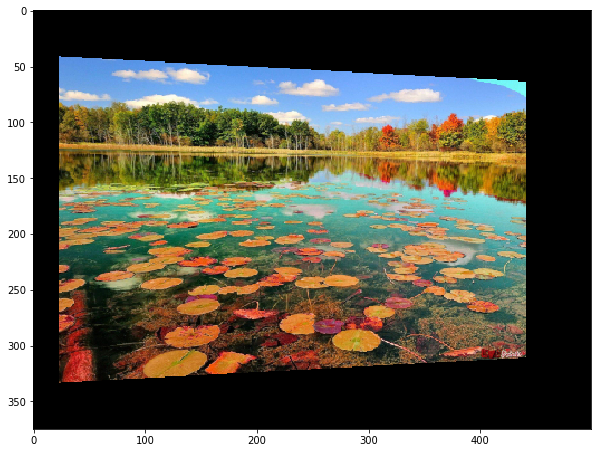

In [74]:
rec = transformed_batch[0].numpy().transpose(1,2,0)
rec.shape
plt.imshow (rec)

In [76]:
# just a test
tb = transformed_batch.clone()
print(tb.shape)
tb.transpose_(3,2).shape

torch.Size([2, 3, 375, 500])


torch.Size([2, 3, 500, 375])

Following is a sanity check. Compare the result with the source, only when the tramsformation is identity.

In [24]:
rec = (rec * 255).astype(np.uint8)
rec[100, 10:20]

array([[0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0]], dtype=uint8)

In [15]:
im[100, 10:20]

Array([[185, 134,  51],
       [171, 123,  47],
       [163, 116,  46],
       [179, 136,  57],
       [172, 132,  44],
       [194, 153,  61],
       [191, 150,  62],
       [177, 137,  52],
       [172, 132,  47],
       [176, 135,  43]], dtype=uint8)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


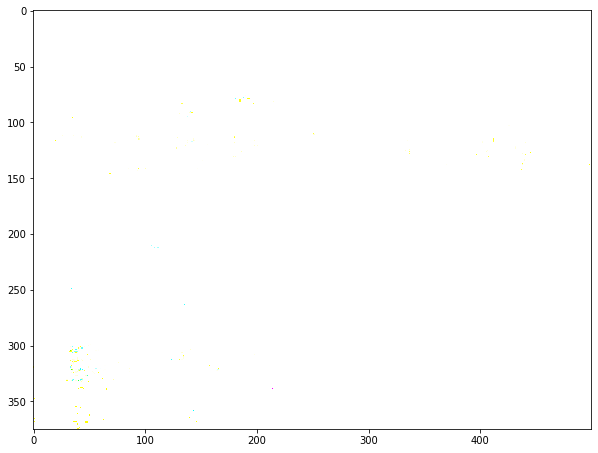

In [72]:
diff_im = np.abs(rec - im)
plt.imshow(diff_im)

In [17]:
diff_im.max()

0